In [290]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

pythonPackagePath = "/Users/johannesschoeneberg/git/pyLattice/src/python/"
sys.path.append(pythonPackagePath+"/modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append(pythonPackagePath+"/classes")
import Track

# input data

In [291]:
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_DMSO_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_JASP_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])
#inputParameters = pd.read_csv(pythonPackagePath+'../../input/big_data_LY_cutoff7000_bleachCorrected/_inputParameters.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")
print(inputDataFolder)
print(outputDataFolder)
inputDataFolder = inputDataFolder.replace("6big","Samsung_T3b")#'/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/'
outputDataFolder = outputDataFolder.replace("6big","Samsung_T3b")#'/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample7_CD_LY_10ulMG__Position2_O1_bleachCorr/output/'
print(inputDataFolder)
print(outputDataFolder)

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))


print(framerate_msec)


/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/
/Volumes/6big/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/output/
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/output/
5689.0


In [292]:
slave_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
master_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/
--- example of files found: S5P2_488_150mw_560_300mw_10ms_dz200nm_ch0_CAM1_stack0000_488nm_0000000msec_0019413653msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
--- number of files found: 70
--- folder searched in: /Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/
--- example of files found: S5P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0019413653msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
--- number of files found: 70


/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr//S5P2_488_150mw_560_300mw_10ms_dz200nm_ch1_CAM1_stack0000_560nm_0000000msec_0019413653msecAbs_000x_000y_003z_0000t_decon.tif_ratioCorrected.tif
(126, 704, 512)


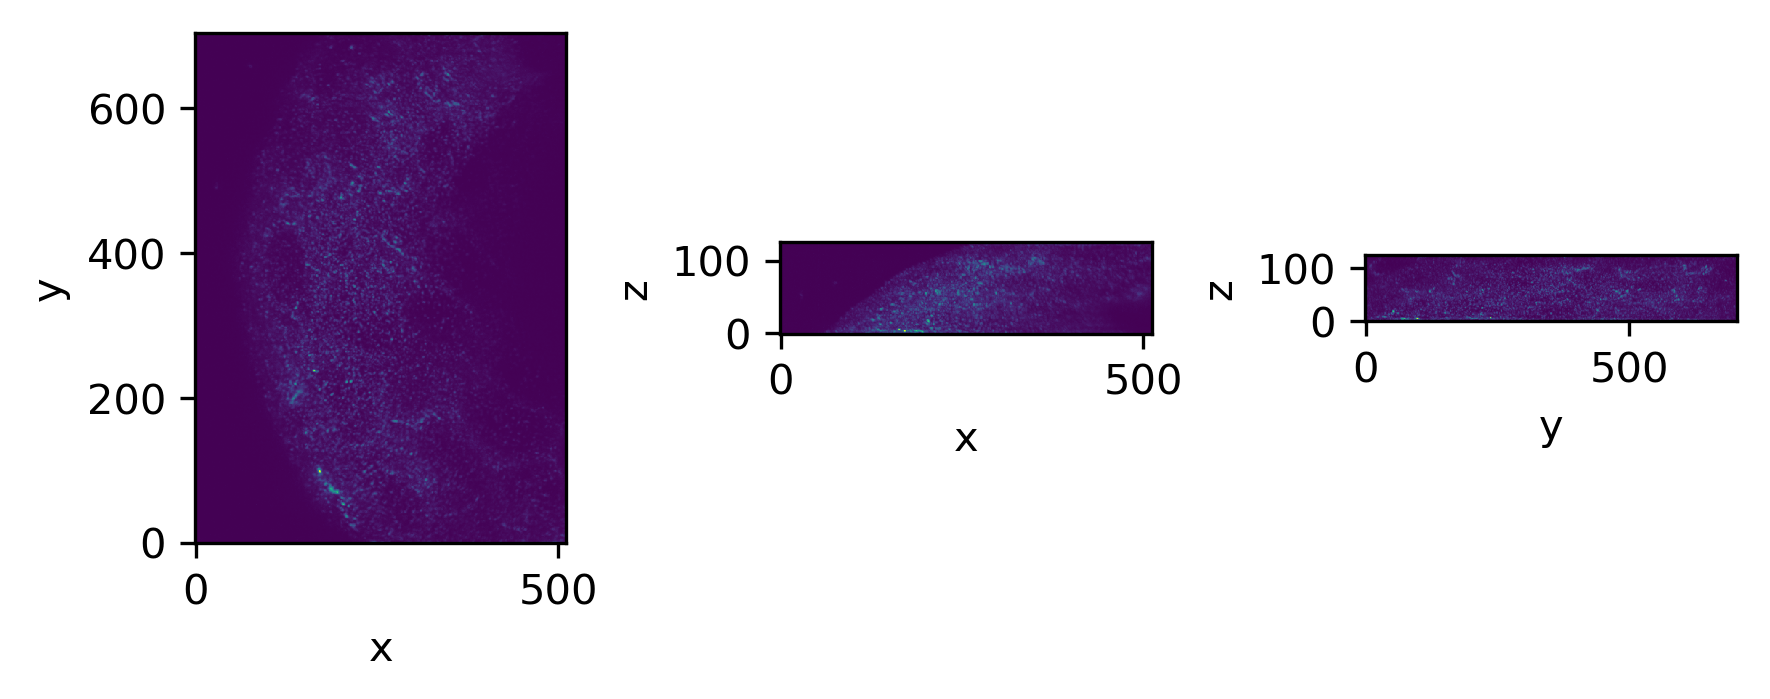

In [293]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

# determine the apical basolateral boundary

In [295]:
path = outputDataFolder+'/'+master_outputDataFolder+'/'
#path = "/Users/johannesschoeneberg/Desktop/PostDoc/drubin_lab/organoids_lattice_data/matlab_lsm_tools_aguet/data_560/"

allAverageZs = []
for i in range(1,71):
        
    filename = "puncta_"+str(i).zfill(3)+".csv"
    data = pd.read_csv(path+"/"+filename,header=0)
    data.columns = ["x","y","z","A"]
    
    # get all puncta
    
    idx = data.index[data['A'] > 0]

    # every axis is flippped in the matlab code (weird, I know)
    x = ((data['x']).loc[idx])
    y = ((data['y']).loc[idx])
    z = ((data['z']).loc[idx])
    
    yrange = [np.min(y),np.max(y)]
    xrange = [np.min(x),np.max(x)]
    #print(yrange)
    #print(xrange)
    yrange = [0,700]
    xrange = [0,500]
    nbins = 20
    xbinsize = (yrange[1]-yrange[0])/nbins
    ybinsize = (xrange[1]-xrange[0])/nbins
    
    xbins = np.arange(xrange[0], xrange[1]+1, xbinsize )
    ybins = np.arange(yrange[0], yrange[1]+1, ybinsize )
    zValues = []
    #print(bins)
    for i in range(1,len(xbins)):
        for j in range(1,len(ybins)):
            xleftThreshold = xbins[i-1]
            xrightThreshold = xbins[i]
            yleftThreshold = ybins[j-1]
            yrightThreshold = ybins[j]
            
            #filter out the z's that have the correct x range
            idx = data.index[(data['y'] > yleftThreshold)&(data['y'] < yrightThreshold)&(data['x'] > xleftThreshold)&(data['x'] < xrightThreshold)] 
            z = ((data['z']).loc[idx])
            zValues.append([xleftThreshold,xrightThreshold,yleftThreshold,yrightThreshold,z.values])
        
    #print(zValues)
    averageZs = []
    for zValuePerBin in zValues:
        averageZs.append(np.array([zValuePerBin[0]+(zValuePerBin[1]-zValuePerBin[0])/2,zValuePerBin[2]+(zValuePerBin[3]-zValuePerBin[2])/2,np.average(zValuePerBin[-1])]))
    
    averageZs = np.array(averageZs)


    allAverageZs.append(averageZs)
    



/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


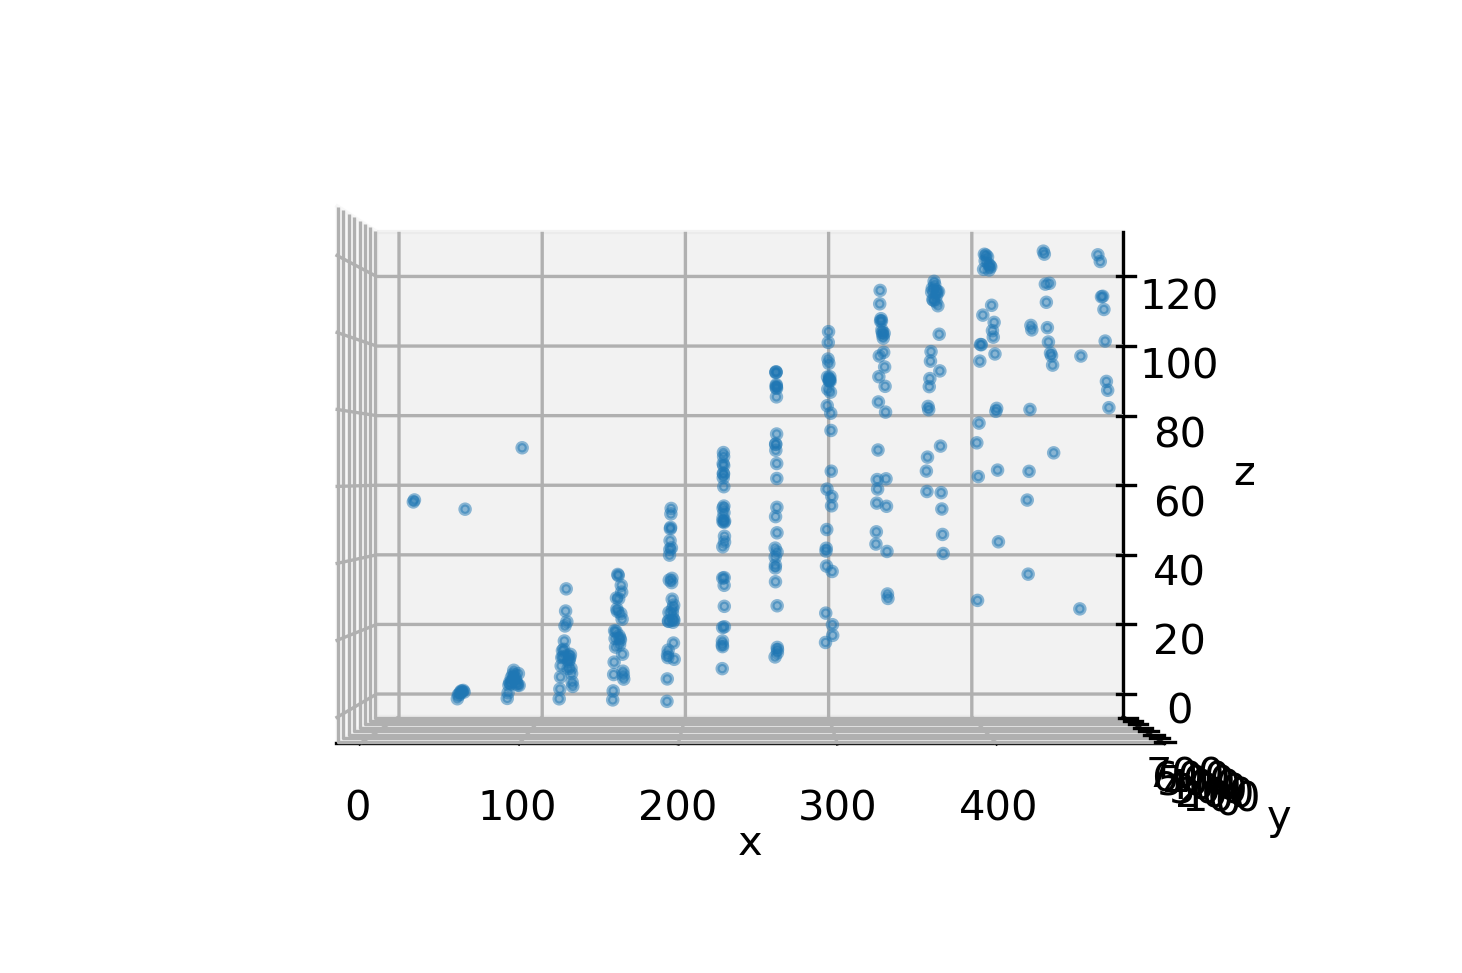

In [296]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
#X, Y, Z = axes3d.get_test_data(0.1)
#ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

#averageZs = allAverageZs[0]

averagedThresholdOverAllFrames = np.nanmean(allAverageZs[0:-1],axis=0)
averageZs = averagedThresholdOverAllFrames

plt.figure(dpi=300)

ax = plt.axes(projection='3d')
#    plt.title(title)
# Data for a three-dimensional line
x = averageZs[:,0]
y = averageZs[:,1]
z = averageZs[:,2]

#    ax.plot3D(x, y, z, 'gray')
ax.scatter3D(x, y, z, cmap='cool',alpha=0.5,s=5);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xangle = 0#90
yangle = -90
ax.view_init(xangle, yangle)
    
# rotate the axes and update
#for angle in range(0, 360):
#    
#    plt.draw()
#    plt.pause(.001)

In [367]:
print(y)

[  12.5   37.5   62.5   87.5  112.5  137.5  162.5  187.5  212.5  237.5
  262.5  287.5  312.5  337.5  362.5  387.5  412.5  437.5  462.5  487.5
  512.5  537.5  562.5  587.5  612.5  637.5  662.5  687.5   12.5   37.5
   62.5   87.5  112.5  137.5  162.5  187.5  212.5  237.5  262.5  287.5
  312.5  337.5  362.5  387.5  412.5  437.5  462.5  487.5  512.5  537.5
  562.5  587.5  612.5  637.5  662.5  687.5   12.5   37.5   62.5   87.5
  112.5  137.5  162.5  187.5  212.5  237.5  262.5  287.5  312.5  337.5
  362.5  387.5  412.5  437.5  462.5  487.5  512.5  537.5  562.5  587.5
  612.5  637.5  662.5  687.5   12.5   37.5   62.5   87.5  112.5  137.5
  162.5  187.5  212.5  237.5  262.5  287.5  312.5  337.5  362.5  387.5
  412.5  437.5  462.5  487.5  512.5  537.5  562.5  587.5  612.5  637.5
  662.5  687.5   12.5   37.5   62.5   87.5  112.5  137.5  162.5  187.5
  212.5  237.5  262.5  287.5  312.5  337.5  362.5  387.5  412.5  437.5
  462.5  487.5  512.5  537.5  562.5  587.5  612.5  637.5  662.5  687.5
   12.

In [297]:
averagedThresholdOverAllFrames[0]

array([ 17.5,  12.5,   nan])

In [298]:
#averagedThresholdOverAllFrames[(averagedThresholdOverAllFrames[0]==35.)]
idx = np.where((averagedThresholdOverAllFrames[:,0]==17.5)&(averagedThresholdOverAllFrames[:,1]==12.5))
averagedThresholdOverAllFrames[idx]

array([[ 17.5,  12.5,   nan]])

# postprocess the thresholds so that they work

In [299]:
#print(averagedThresholdOverAllFrames)
print(averagedThresholdOverAllFrames)
averagedThresholdOverAllFrames[:,2]=abs(averagedThresholdOverAllFrames[:,2]-120)
print()
print(averagedThresholdOverAllFrames)

[[  17.5          12.5                  nan]
 [  17.5          37.5                  nan]
 [  17.5          62.5                  nan]
 ..., 
 [ 472.5         637.5          24.96147978]
 [ 472.5         662.5                  nan]
 [ 472.5         687.5                  nan]]

[[  17.5          12.5                  nan]
 [  17.5          37.5                  nan]
 [  17.5          62.5                  nan]
 ..., 
 [ 472.5         637.5          95.03852022]
 [ 472.5         662.5                  nan]
 [ 472.5         687.5                  nan]]


# read the tracking data for splitting

In [300]:
# read the raw csv data for further processing

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]





/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/output//trackedFeaturesProcessed.csv
/Volumes/Samsung_T3b/science/daphne_data_processing/2016-04-28Daphne__Sample5_CD_JASP_10ulMG__Position2_O1_bleachCorr/output//trackedFeaturesProcessed.csv


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trackId,tracklength,time[s],frameId,lifetime,catIdx,m_x,m_y,m_z,m_A,m_c,m_pval_Ar,s_x,s_y,s_z,s_A,s_c,s_pval_Ar
0,1,70,0,1,398.23,4,1.699583e+02,3.527017e+02,1.122072e+02,4.858301e+04,1.606842e+03,0,1.689722e+02,3.523189e+02,1.122072e+02,4.242920e+04,7.473002e+03,0
1,1,70,5.689000e+00,2,398.23,4,1.699391e+02,3.529361e+02,1.121235e+02,4.656957e+04,1.831141e+03,0,1.693161e+02,3.531346e+02,1.121235e+02,3.247438e+04,7.269251e+03,1.138781e-310
2,1,70,1.137800e+01,3,398.23,4,1.702399e+02,3.531697e+02,1.116362e+02,3.706077e+04,1.885012e+03,0,1.693273e+02,3.528318e+02,1.116362e+02,3.499283e+04,9.523957e+03,3.682129e-256
3,1,70,1.706700e+01,4,398.23,4,1.706486e+02,3.530022e+02,1.116391e+02,3.608603e+04,1.809285e+03,0,1.696545e+02,3.529128e+02,1.116391e+02,3.094670e+04,7.341001e+03,5.465297e-271
4,1,70,2.275600e+01,5,398.23,4,1.714630e+02,3.536735e+02,1.110808e+02,3.228757e+04,1.702633e+03,0,1.704900e+02,3.532626e+02,1.110808e+02,2.794753e+04,6.367569e+03,0


# select subset

In [301]:
# select a subset of the tracks, e.g. for displaying only long tracks

#%----------------------------------------------------------------------------
#    % I. Assign category to each track
#    %----------------------------------------------------------------------------
#    % Categories:
#    % Ia)  Single tracks with valid gaps
#    % Ib)  Single tracks with invalid gaps
#    % Ic)  Single tracks cut at beginning or end
#    % Id)  Single tracks, persistent
#    % IIa) Compound tracks with valid gaps
#    % IIb) Compound tracks with invalid gaps
#    % IIc) Compound tracks cut at beginning or end
#    % IId) Compound tracks, persistent
#    
#    % The categories correspond to index 1-8, in the above order

allTrackIdsLrgrThanFour = (data[data['tracklength'] >= 4]).drop_duplicates(subset='trackId')['trackId'].values
allTrackIds = np.unique(data['trackId'].values)
cat_Ia_Tracks = np.unique(data[data['catIdx'] == 1]['trackId'])
cat_Ia_Tracks_long = np.unique(data[((data['catIdx'] == 1) & (data['tracklength'] > 4))]['trackId'])
cat_Ib_Tracks = np.unique(data[data['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(data[data['catIdx'] == 3]['trackId'])
cat_Ic_Tracks_long = np.unique(data[((data['catIdx'] == 3) & (data['tracklength'] > 4))]['trackId'])
cat_Id_Tracks = np.unique(data[data['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(data[data['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(data[data['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(data[data['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(data[data['catIdx'] == 8]['trackId'])


print('len(allTrackIdsLrgrThanFour)/len(allTrackIds)')
print(str(len(allTrackIdsLrgrThanFour))+'/'+str(len(allTrackIds)))
print()
print(allTrackIdsLrgrThanFour)
print('/')
print(allTrackIds)
print()

len(allTrackIdsLrgrThanFour)/len(allTrackIds)
13669/26661

[    1     2     3 ..., 16820 16967 17901]
/
[    1     2     3 ..., 26659 26660 26661]



[26661, 13669, 18762, 6012, 16, 6093, 3038, 7, 839, 0, 941, 3]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Text(0.5,1,'N all: = 26661')

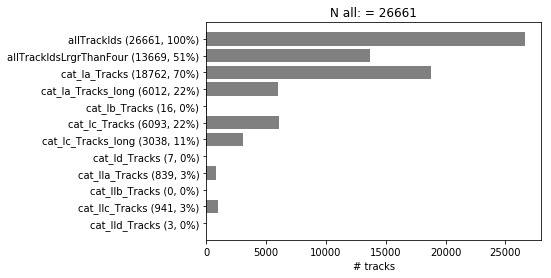

In [302]:
# plot a statistics fo the tracks in the different categories
categories = [allTrackIds,allTrackIdsLrgrThanFour,cat_Ia_Tracks,cat_Ia_Tracks_long,cat_Ib_Tracks,cat_Ic_Tracks,cat_Ic_Tracks_long,cat_Id_Tracks,cat_IIa_Tracks,cat_IIb_Tracks,cat_IIc_Tracks,cat_IId_Tracks]
categoryLabels = ["allTrackIds","allTrackIdsLrgrThanFour","cat_Ia_Tracks","cat_Ia_Tracks_long","cat_Ib_Tracks","cat_Ic_Tracks","cat_Ic_Tracks_long","cat_Id_Tracks","cat_IIa_Tracks","cat_IIb_Tracks","cat_IIc_Tracks","cat_IId_Tracks"]

categoryFrequency = []
for i in range(0,len(categories)):
    cat = categories[i]
    categoryFrequency.append(len(cat))
    percentage = int(len(cat)/len(allTrackIds)*100)
    categoryLabels[i]= categoryLabels[i]+' ('+str(len(cat))+', '+str(percentage)+'%)'
    
print(categoryFrequency)
fig, ax = plt.subplots()
y_pos = np.arange(len(categoryFrequency))

error = np.random.rand(len(categoryFrequency))
error = np.zeros(len(categoryFrequency))
print(error)

ax.barh(y_pos, categoryFrequency, xerr=error, align='center',
        color='grey', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(categoryLabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# tracks')
ax.set_title('N all: = '+str(len(allTrackIds)))

In [303]:
import re
def parseCutString(string):
    result = []
    #pattern match the indexing string
    chunks = re.findall("\\[[0-9]+,[0-9]+\\]",string)
    for chunk in chunks:
        indexes = re.findall("[0-9]+",chunk)
        if(len(indexes)==2):
            result.append([int(indexes[0]),int(indexes[1])])
        else:
            print("error: index \""+indexes+"\" cannot be parsed")

    return result

In [304]:
# align them all to the max

In [305]:

lifetimeCohorts = [[0, 6], [6,12],[12,18],[18,24],[24,30],[30,70]] #frames


In [306]:
print(xbinsize)

35.0


In [335]:
# data preprocessing

#maxIndexSlaveMustBeLargerThan = 0
SlaveMaxAfterPercentCohortLength = 0.6
#trackIdsUsed = allTrackIds
trackIdsUsed = cat_Ia_Tracks_long

# take only those tracks that belong to the cohort:

#initialize the trackId array sorted by lifetime cohort
trackIdsAssignedToCohorts_api = []
trackIdsAssignedToCohorts_baso = []
for i in range(0,len(lifetimeCohorts)):
    trackIdsAssignedToCohorts_api.append(np.array([]))
    trackIdsAssignedToCohorts_baso.append(np.array([]))



baso = False

basoFirstXYZ=[]
basoLifetimes=[]
baso_mAmplitude=[] 
baso_sAmplitude=[]  
apiFirstXYZ=[]
apiLifetimes=[]
api_mAmplitude=[]
api_sAmplitude=[]

maxXIdxValue = max(averagedThresholdOverAllFrames[:,0])
maxYIdxValue = max(averagedThresholdOverAllFrames[:,1])


for trackId in trackIdsUsed:
    track = data[data['trackId'] == trackId]
    tracklength = track['tracklength'].values[0]
    m_intensity = track['m_A'].values.astype(float)
    s_intensity = track['s_A'].values.astype(float)
    maxIdx = np.argmax(s_intensity)
    # only include those tracks that do not have the dynamin peak in the first three frames
    
    m_firstX = track['m_x'].values.astype(float)[0]
    m_firstY = track['m_y'].values.astype(float)[0]
    m_firstZ = track['m_z'].values.astype(float)[0]
    
    #determine into which x-y-bin for the zThreshold this track belongs
    xIdxValue = int(np.floor(m_firstX/xbinsize))*xbinsize +xbinsize/2     
    yIdxValue = int(np.floor(m_firstY/ybinsize))*ybinsize +ybinsize/2
    
    # if the puncta happens to be outside the grid, catch it again
    if(xIdxValue>maxXIdxValue):
        xIdxValue = maxXIdxValue 
    if(yIdxValue>maxYIdxValue):
        yIdxValue = maxYIdxValue
    
    #print("{}. {}".format(xIdxValue,yIdxValue))
    indexForThresholdArray = np.where((averagedThresholdOverAllFrames[:,0]==xIdxValue)&(averagedThresholdOverAllFrames[:,1]==yIdxValue))

    if(len(indexForThresholdArray[0])>0):
        zThreshold_apibaso =  averagedThresholdOverAllFrames[indexForThresholdArray][0][-1]
        #print(zThreshold_apibaso)
        if (np.isnan(zThreshold_apibaso)):
            zThreshold_apibaso = 0
    
        if(m_firstZ < zThreshold_apibaso):
            baso = False
            apiFirstXYZ.append([m_firstX,m_firstY,m_firstZ])
            apiLifetimes.append(tracklength)
            api_mAmplitude.append(m_intensity)
            api_sAmplitude.append(s_intensity)
        else:
            baso = True
            basoFirstXYZ.append([m_firstX,m_firstY,m_firstZ])
            basoLifetimes.append(tracklength)
            baso_mAmplitude.append(m_intensity)
            baso_sAmplitude.append(s_intensity)
    
                    
            
        
        
        for i in range(0,len(lifetimeCohorts)):
            lifetimeLength = lifetimeCohorts[i][1]-lifetimeCohorts[i][0]
            #if(maxIdx >=maxIndexSlaveMustBeLargerThan):
            if(maxIdx >=SlaveMaxAfterPercentCohortLength*lifetimeLength):
                
                if((tracklength >lifetimeCohorts[i][0]) & (tracklength <=lifetimeCohorts[i][1])):
                    if(baso):
                        trackIdsAssignedToCohorts_baso[i] = np.append(trackIdsAssignedToCohorts_baso[i],trackId)
                    else:
                        trackIdsAssignedToCohorts_api[i] = np.append(trackIdsAssignedToCohorts_api[i],trackId)
                
    else:
        #print(averagedThresholdOverAllFrames)
        print(indexForThresholdArray)
        print(m_firstX)
        print(m_firstY)
        print(m_firstZ)
        print(xIdxValue)
        print(yIdxValue)
        print('what?')
trackIdsAssignedToCohorts_api = np.array(trackIdsAssignedToCohorts_api)
trackIdsAssignedToCohorts_baso = np.array(trackIdsAssignedToCohorts_baso)


api_cohorts_n = []
#print(trackIdsAssignedToCohorts_api)
for cohortIdArray in trackIdsAssignedToCohorts_api:
    print(len(cohortIdArray))
    api_cohorts_n.append(len(cohortIdArray))
    
print()
baso_cohorts_n = []
#print(trackIdsAssignedToCohorts_baso)
for cohortIdArray in trackIdsAssignedToCohorts_baso:
    print(len(cohortIdArray))
    baso_cohorts_n.append(len(cohortIdArray))

283
556
143
40
10
3

467
1155
349
152
52
28


In [336]:
print("are all tracks classified?\n baso: {}, api: {}, both: {}, all: {}".format(np.sum(baso_cohorts_n),np.sum(api_cohorts_n),np.sum(baso_cohorts_n)+np.sum(api_cohorts_n),len(trackIdsUsed)))

are all tracks classified?
 baso: 2203, api: 1035, both: 3238, all: 6012


Text(0,0.5,'z[px]')

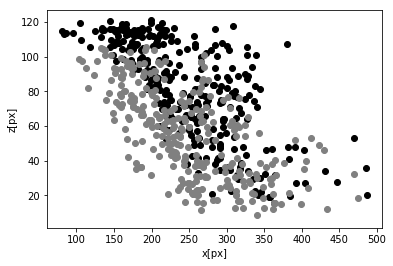

In [365]:
slicee=200
plt.scatter(np.array(basoFirstXYZ)[300:600,0],np.array(basoFirstXYZ)[300:600,2],c='k')
plt.scatter(np.array(apiFirstXYZ)[300:600,0],np.array(apiFirstXYZ)[300:600,2],c='grey')
plt.xlabel('x[px]')
plt.ylabel('z[px]')

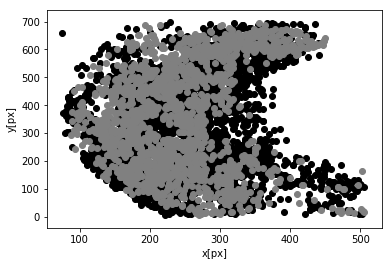

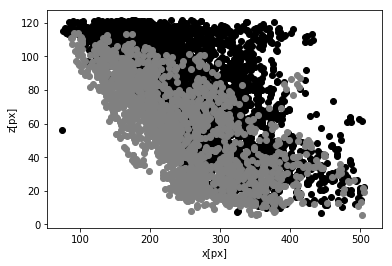

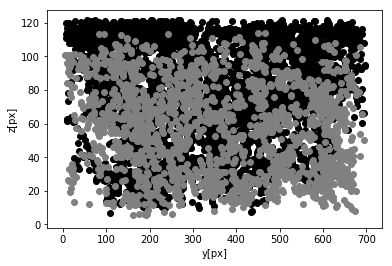

In [337]:
plt.scatter(np.array(basoFirstXYZ)[:,0],np.array(basoFirstXYZ)[:,1],c='k')
plt.scatter(np.array(apiFirstXYZ)[:,0],np.array(apiFirstXYZ)[:,1],c='grey')

plt.xlabel('x[px]')
plt.ylabel('y[px]')
plt.show()
plt.scatter(np.array(basoFirstXYZ)[:,0],np.array(basoFirstXYZ)[:,2],c='k')
plt.scatter(np.array(apiFirstXYZ)[:,0],np.array(apiFirstXYZ)[:,2],c='grey')
plt.xlabel('x[px]')
plt.ylabel('z[px]')
plt.show()
plt.scatter(np.array(basoFirstXYZ)[:,1],np.array(basoFirstXYZ)[:,2],c='k')
plt.scatter(np.array(apiFirstXYZ)[:,1],np.array(apiFirstXYZ)[:,2],c='grey')
plt.xlabel('y[px]')
plt.ylabel('z[px]')
plt.show()



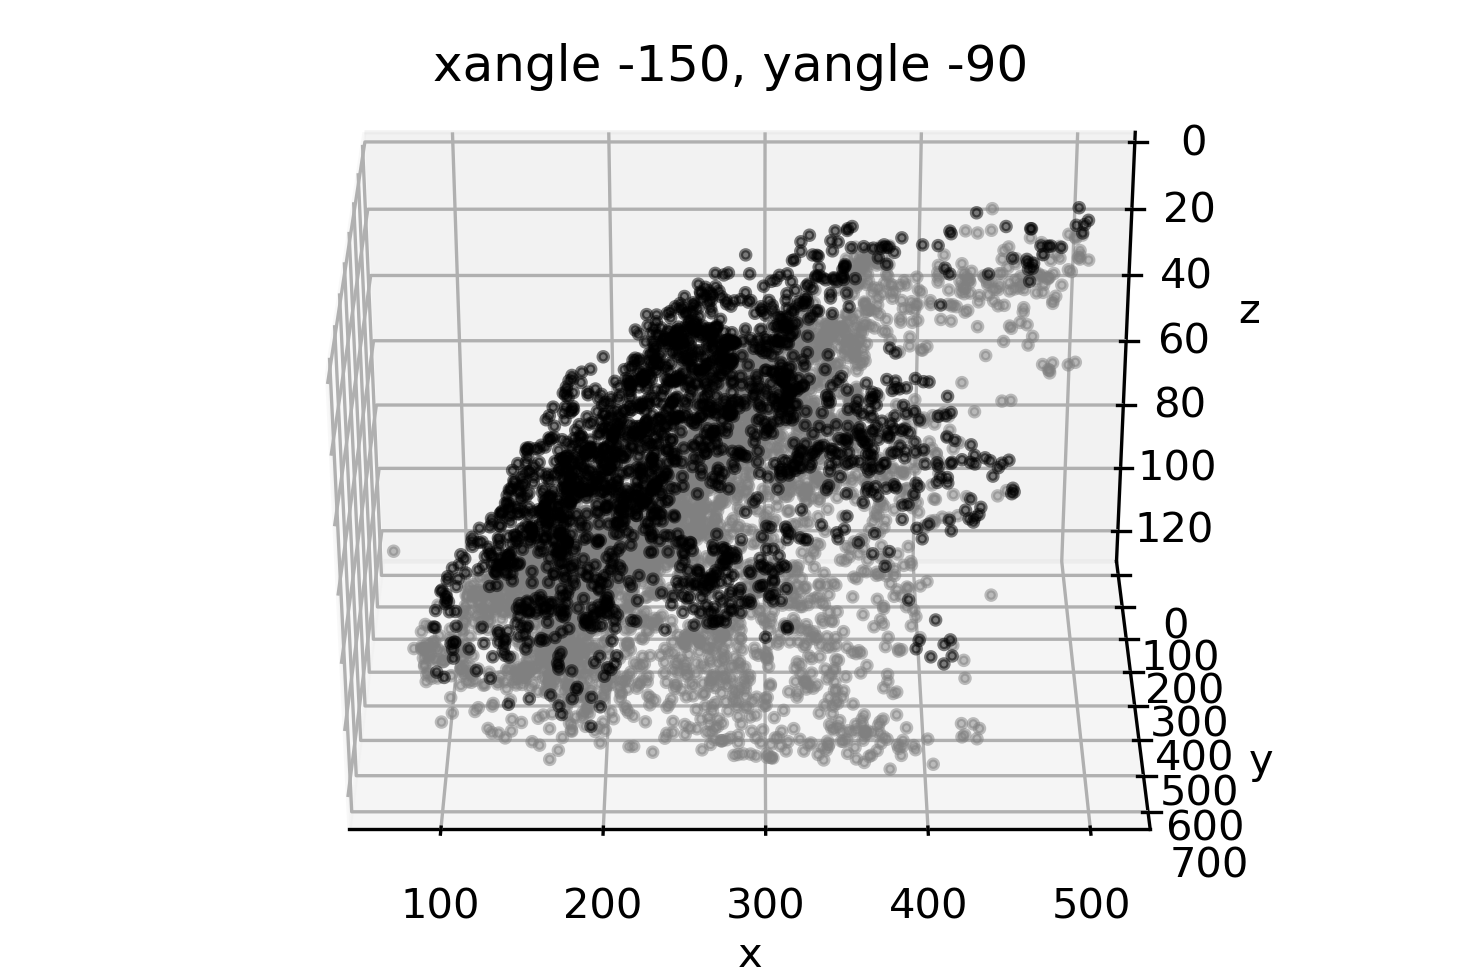

In [338]:
plt.figure(dpi=300)
ax = plt.axes(projection='3d')
ax.scatter3D(np.array(basoFirstXYZ)[:,0], np.array(basoFirstXYZ)[:,1], np.array(basoFirstXYZ)[:,2], color='grey',alpha=0.5,s=5);
ax.scatter3D(np.array(apiFirstXYZ)[:,0], np.array(apiFirstXYZ)[:,1], np.array(apiFirstXYZ)[:,2], color='k',alpha=0.5,s=5);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xangle = -150#90
yangle = -90
ax.view_init(xangle, yangle)
plt.title('xangle {}, yangle {}'.format(xangle,yangle))
plt.show()

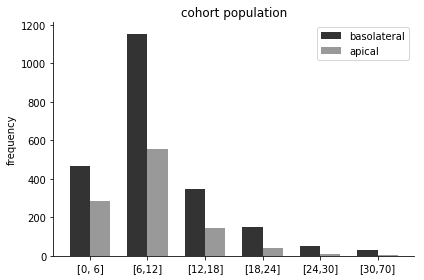

In [339]:
# data to plot

A = (baso_cohorts_n[0], baso_cohorts_n[1],baso_cohorts_n[2],baso_cohorts_n[3],baso_cohorts_n[4],baso_cohorts_n[5])
B = (api_cohorts_n[0], api_cohorts_n[1],api_cohorts_n[2],api_cohorts_n[3],api_cohorts_n[4],api_cohorts_n[5])
n_groups = len(A) 
    
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, A, bar_width,
                 alpha=opacity,
                 color='k',
                 label='basolateral')
 
rects2 = plt.bar(index + bar_width, B, bar_width,
                 alpha=opacity,
                 color='grey',
                 label='apical')
 
#plt.xlabel('Person')
plt.ylabel('frequency')
plt.title('cohort population')
plt.xticks(index + bar_width/2, ('[0, 6]', '[6,12]','[12,18]', '[18,24]', '[24,30]','[30,70]'))

plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
 
plt.tight_layout()
plt.show()


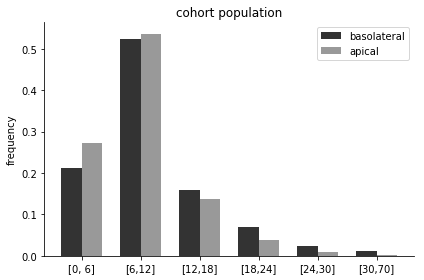

In [340]:
# data to plot normalized
    
A = (baso_cohorts_n[0], baso_cohorts_n[1],baso_cohorts_n[2],baso_cohorts_n[3],baso_cohorts_n[4],baso_cohorts_n[5])/np.sum(baso_cohorts_n)
B = (api_cohorts_n[0], api_cohorts_n[1],api_cohorts_n[2],api_cohorts_n[3],api_cohorts_n[4],api_cohorts_n[5])/np.sum(api_cohorts_n)
n_groups = len(A) 
    
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, A, bar_width,
                 alpha=opacity,
                 color='k',
                 label='basolateral')
 
rects2 = plt.bar(index + bar_width, B, bar_width,
                 alpha=opacity,
                 color='grey',
                 label='apical')
 
#plt.xlabel('Person')
plt.ylabel('frequency')
plt.title('cohort population')
#plt.xticks(index + bar_width/2, ('[0, 6]', '[6,12]','[12,18]', '[18,50]', '[50,70]'))
plt.xticks(index + bar_width/2, ('[0, 6]', '[6,12]','[12,18]', '[18,24]', '[24,30]','[30,70]'))

plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
 
plt.tight_layout()
plt.show()



In [341]:
print(len(trackIdsUsed))

6012


Text(0,0.5,'frequency')

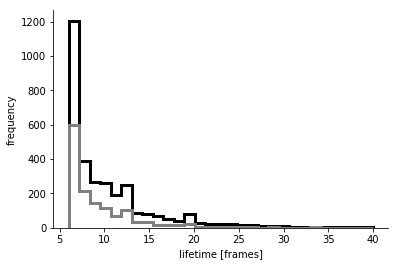

In [342]:
#plt.plot(basoLifetimes)
#plt.plot(apiLifetimes)
plt.hist(basoLifetimes,histtype='step',linewidth=3,color='k',bins=np.linspace(6, 40, 30));
plt.hist(apiLifetimes,histtype='step',linewidth=3,color='grey',bins=np.linspace(6, 40, 30));
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.xlim(7.5,30)
#plt.ylim(0,400)
plt.xlabel('lifetime [frames]')
plt.ylabel('frequency')

In [343]:
def flattenList(array):
    return np.array([item for sublist in array for item in sublist])


(array([     0.,      0.,      0.,      0.,      0.,  37973.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

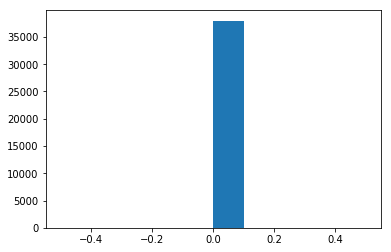

In [344]:
plt.hist(np.isnan(flattenList(baso_mAmplitude)))

In [345]:
#  plt.hist(flattenList(baso_mAmplitude),histtype='step',linewidth=3,color='magenta',bins=np.linspace(8000, 50000, 50));
#  plt.hist(flattenList(api_mAmplitude),histtype='step',linewidth=3,color='red',bins=np.linspace(8000, 50000, 50));#,bins=np.linspace(6, 60, 50));
#  #plt.hist(api_mAmplitude,histtype='step')#,bins=np.linspace(6, 60, 50));
#  plt.hist(flattenList(baso_sAmplitude),histtype='step',linewidth=3,color='lime',bins=np.linspace(8000, 50000, 50));
#  plt.hist(flattenList(api_sAmplitude),histtype='step',linewidth=3,color='green',bins=np.linspace(8000, 50000, 50));#
#  plt.gca().spines['right'].set_visible(False)
#  plt.gca().spines['top'].set_visible(False)
#  plt.xlabel('fitted amplitude')
#  plt.ylabel('frequency')

In [346]:
#  plt.hist(flattenList(baso_mAmplitude),histtype='step',linewidth=3,color='magenta',bins=np.linspace(20000, 50000, 30));
#  plt.hist(flattenList(api_mAmplitude),histtype='step',linewidth=3,color='red',bins=np.linspace(20000, 50000, 30));#,bins=np.linspace(6, 60, 50));
#  #plt.hist(api_mAmplitude,histtype='step')#,bins=np.linspace(6, 60, 50));
#  plt.hist(flattenList(baso_sAmplitude),histtype='step',linewidth=3,color='lime',bins=np.linspace(20000, 50000, 30));
#  plt.hist(flattenList(api_sAmplitude),histtype='step',linewidth=3,color='green',bins=np.linspace(20000, 50000, 30));#
#  plt.gca().spines['right'].set_visible(False)
#  plt.gca().spines['top'].set_visible(False)
#  plt.xlabel('fitted amplitude')
#  plt.ylabel('frequency')

In [347]:


def createBufferForLifetimeCohort(listOfTrackIdsAssignedToCohort,    backgroundIntensity ):


    trackIdArray = listOfTrackIdsAssignedToCohort
    
    m_buffer = []
    s_buffer = []
    
    bufferSize = 200
    bufferZero = 100

    
    m_buffer = np.full(( len(trackIdArray),bufferSize), backgroundIntensity,dtype=float)
    s_buffer = np.full(( len(trackIdArray),bufferSize), backgroundIntensity,dtype=float)
    
    
    #for i in range(0,bufferSize):
    #    m_buffer.append([])
    #    s_buffer.append([])
        
    counter = 0
    
    for trackId in trackIdArray:
        track = data[data['trackId'] == trackId]
        tracklength = track['tracklength'].values[0]
        m_intensity = track['m_A'].values.astype(float)
        s_intensity = track['s_A'].values.astype(float)
        maxIdx = np.argmax(s_intensity)
        
    
        for i in range(0,len(track)):
            if(not np.isnan(m_intensity[i])):
                m_buffer[counter][bufferZero-maxIdx+i]=(m_intensity[i])
            if(not np.isnan(s_intensity[i])):
                s_buffer[counter][bufferZero-maxIdx+i]=(s_intensity[i])
           
                
        counter = counter+1;
    
    
    return (m_buffer,s_buffer)



In [348]:


def createBufferForLifetimeCohort_normalized(listOfTrackIdsAssignedToCohort,    backgroundIntensity ):


    trackIdArray = listOfTrackIdsAssignedToCohort
    
    m_buffer = []
    s_buffer = []
    
    bufferSize = 200
    bufferZero = 100

    
    m_buffer = np.full(( len(trackIdArray),bufferSize), backgroundIntensity,dtype=float)
    s_buffer = np.full(( len(trackIdArray),bufferSize), backgroundIntensity,dtype=float)
    
    
    #for i in range(0,bufferSize):
    #    m_buffer.append([])
    #    s_buffer.append([])
        
    counter = 0
    
    for trackId in trackIdArray:
        track = data[data['trackId'] == trackId]
        tracklength = track['tracklength'].values[0]
        m_intensity = track['m_A'].values.astype(float)
        s_intensity = track['s_A'].values.astype(float)
        maxIdx = np.argmax(s_intensity)
        m_maxIntensity = np.nanmax(m_intensity)
        s_maxIntensity = np.nanmax(s_intensity)
        
    
        for i in range(0,len(track)):
            if(not np.isnan(m_intensity[i])):
                m_buffer[counter][bufferZero-maxIdx+i]=(m_intensity[i])/m_maxIntensity
            if(not np.isnan(s_intensity[i])):
                valueToPut = (s_intensity[i])/s_maxIntensity
                #print(valueToPut)
                s_buffer[counter][bufferZero-maxIdx+i]=(s_intensity[i])/s_maxIntensity
                #print(s_buffer[counter])
                
        counter = counter+1;
    
    
    return (m_buffer,s_buffer)


# apical

143


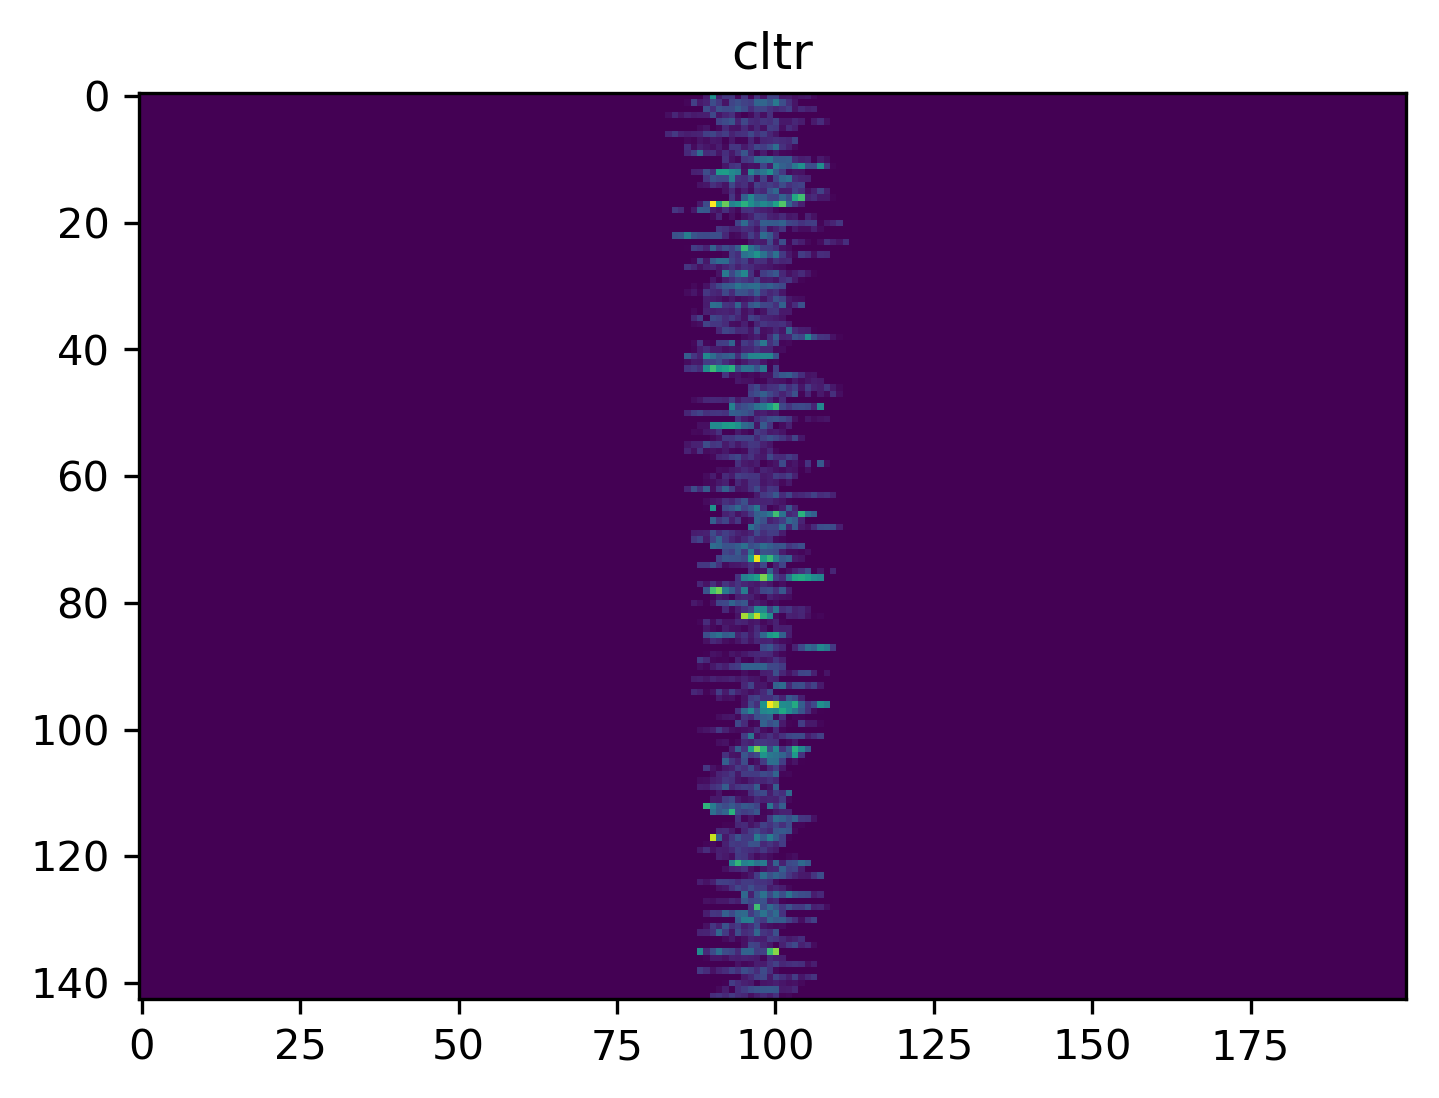

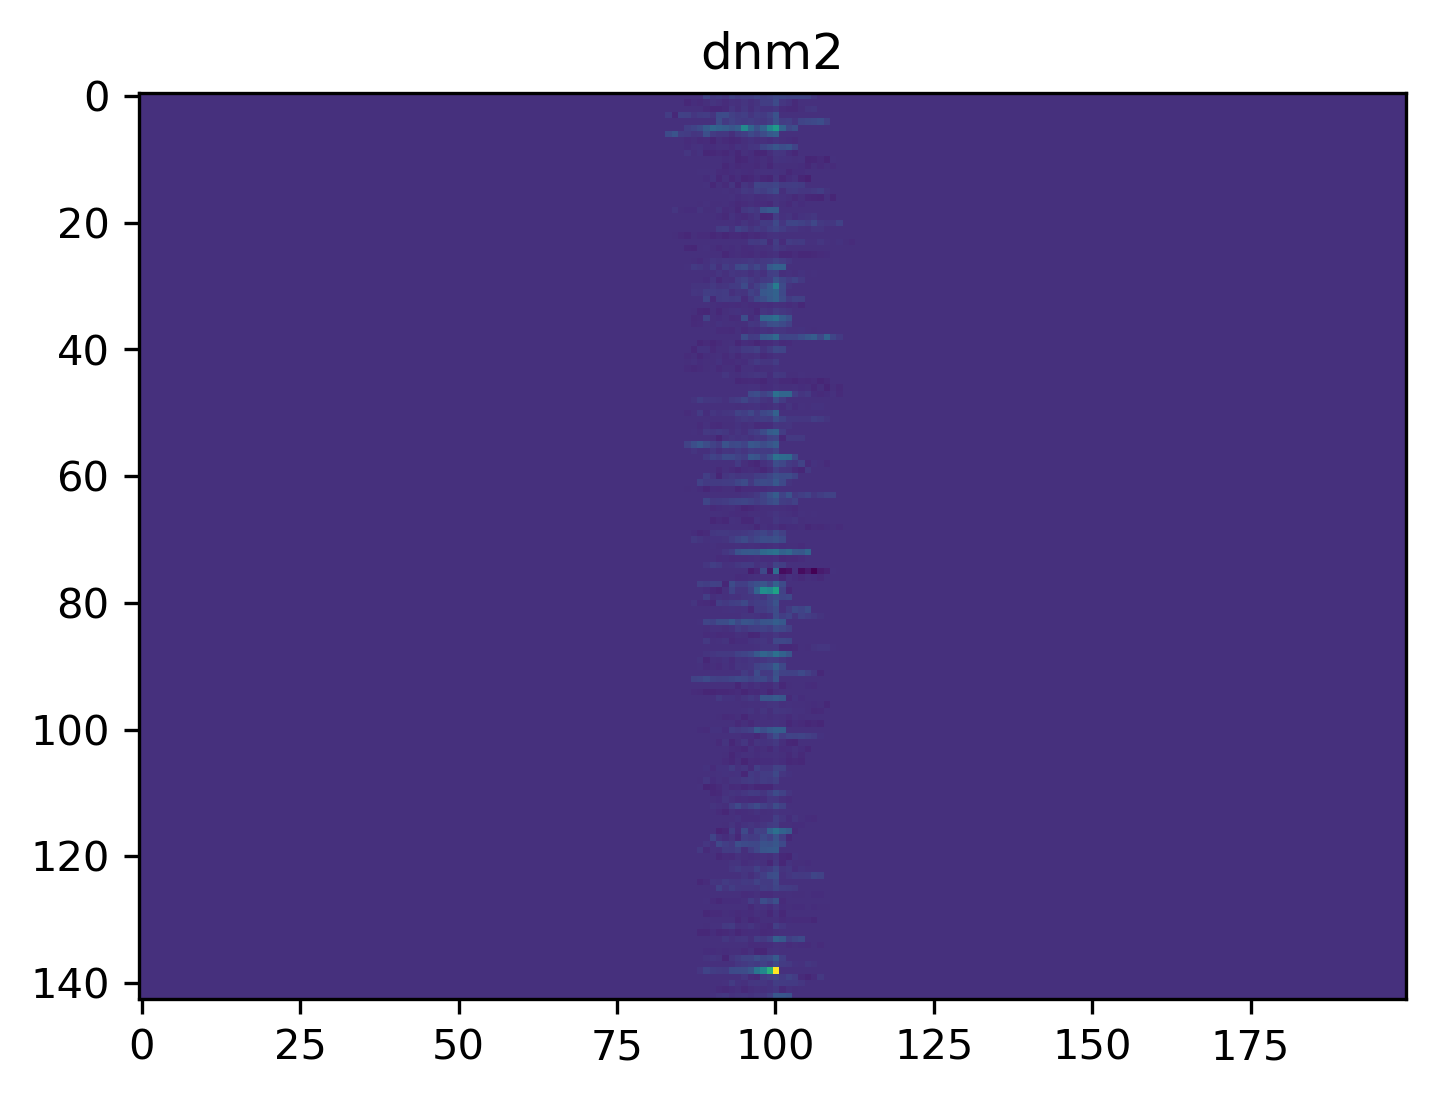

In [349]:
#calculate all the buffers for all cohorts
backgroundIntensity = 7000
cohordIndexDisplayed = 2
cohortBuffers = []
for i in range(0,len(lifetimeCohorts)):
    m_buffer, s_buffer = createBufferForLifetimeCohort(trackIdsAssignedToCohorts_api[i],backgroundIntensity)
    cohortBuffers.append([m_buffer,s_buffer])

m_buffer,s_buffer = cohortBuffers[cohordIndexDisplayed]
print(len(m_buffer))
plt.figure(dpi=300)
plt.title('cltr')
plt.imshow(m_buffer)


plt.figure(dpi=300)
plt.title('dnm2')
plt.imshow(s_buffer)

In [350]:
print(len(cohortBuffers))

6


5 3
4 10
3 40
2 143
1 556
0 283


Text(0.5,1,'Apical')

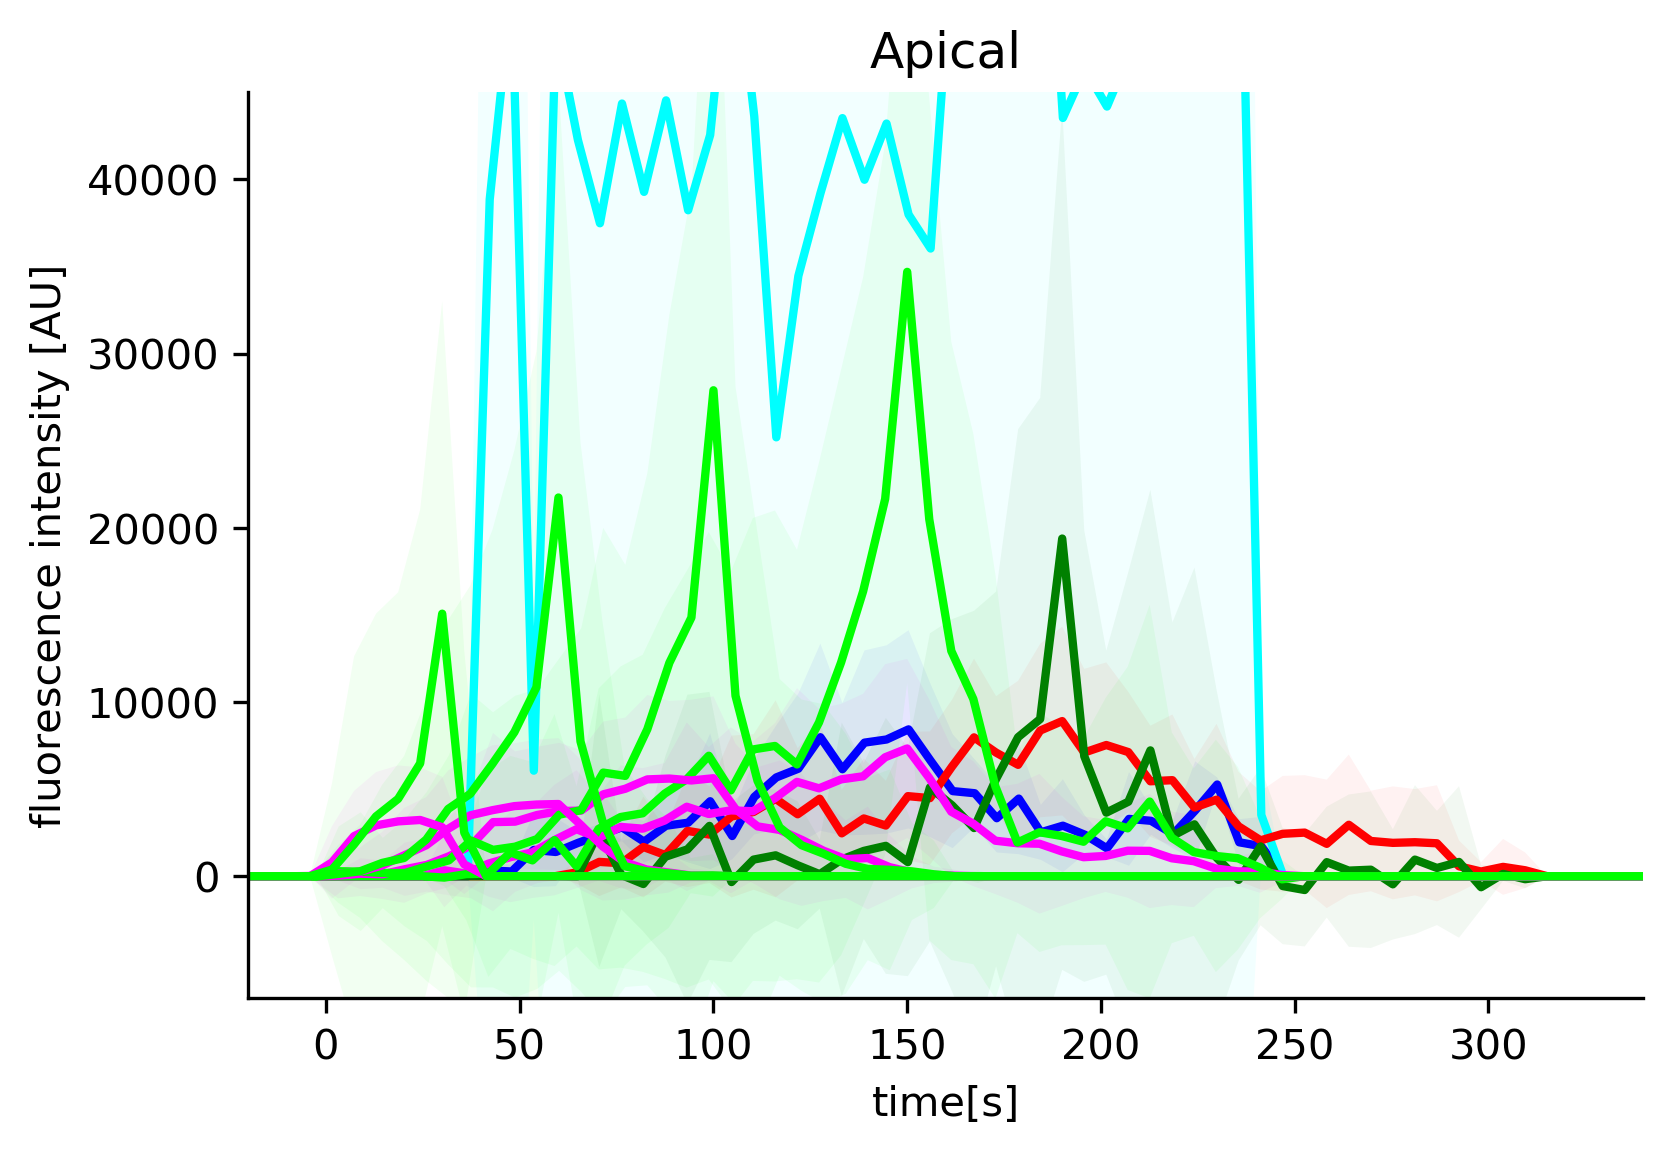

In [351]:

plt.figure(dpi=300)

#m_colors = ['magenta','red','crimson']
#s_colors = ['mediumspringgreen','lawngreen','lime']
m_colors = ['magenta','magenta','magenta','magenta','red','blue']
s_colors = ['lime','lime','lime','lime','green','cyan']
#timeShift = [0,40,95] this shift shifts everything to t=-40

bufferSize = 200
bufferZero = 100


timeShift = np.array([0,30,70,120,160,200]) +30
alph = 0.05
liwi = 2

lengthTreshold = 0


cohortIdx = 5
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):

    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)





#--------

cohortIdx = 4
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)




#-------

cohortIdx = 3
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)

#--------

cohortIdx = 2
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)




#------

cohortIdx = 1
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)



#------

cohortIdx = 0
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-20,340)
plt.ylim(-7000,45000)
plt.xlabel('time[s]')
plt.ylabel('fluorescence intensity [AU]')
plt.title('Apical')

7000


Text(0,0.5,'fluorescence intensity [AU]')

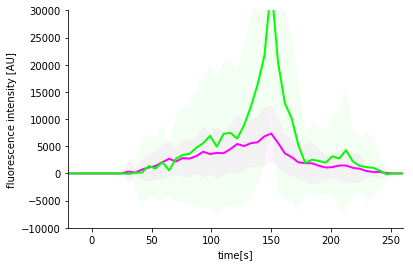

In [352]:
cohortIdx = 3
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(backgroundIntensity)
m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
m_buffer_std = np.nanstd(m_buffer,axis=0)
s_buffer_std = np.nanstd(s_buffer,axis=0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)
plt.xlim(-20,260)
plt.ylim(-10000,30000)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('time[s]')
plt.ylabel('fluorescence intensity [AU]')

# basolateral

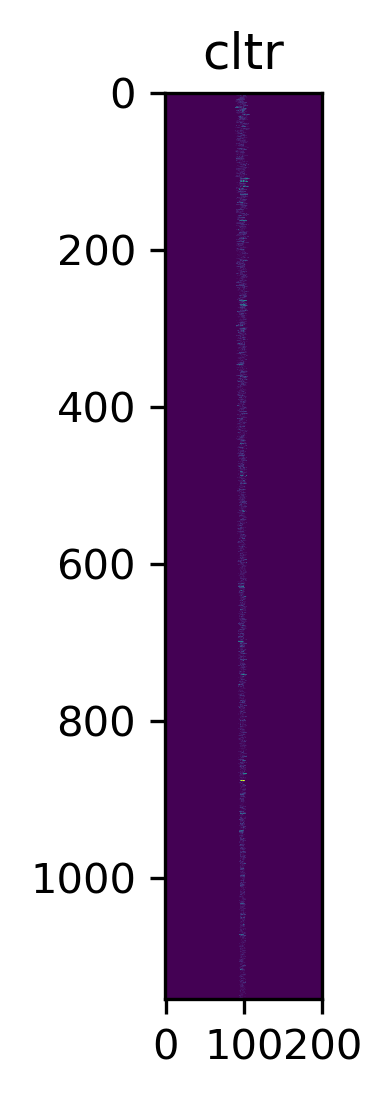

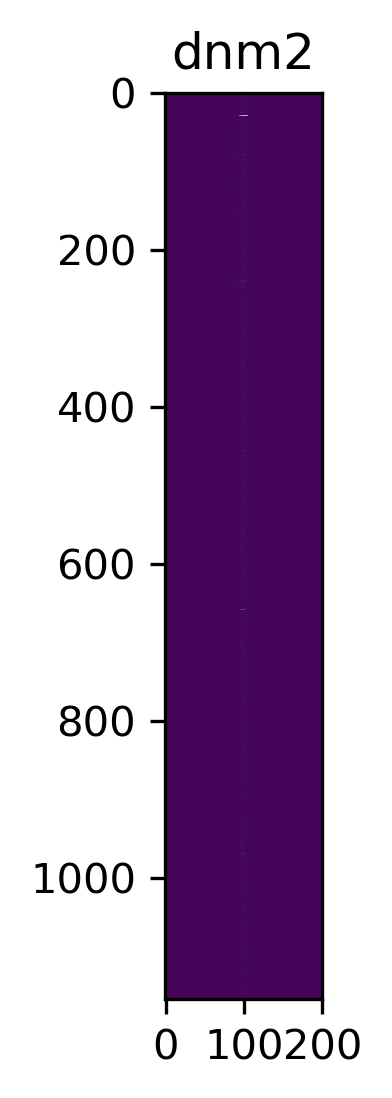

In [353]:
#calculate all the buffers for all cohorts
backgroundIntensity = 7000

cohortBuffers = []
for i in range(0,len(lifetimeCohorts)):
    m_buffer, s_buffer = createBufferForLifetimeCohort(trackIdsAssignedToCohorts_baso[i],backgroundIntensity)
    cohortBuffers.append([m_buffer,s_buffer])

m_buffer,s_buffer = cohortBuffers[1]
plt.figure(dpi=300)
plt.title('cltr')
plt.imshow(m_buffer)


plt.figure(dpi=300)
plt.title('dnm2')
plt.imshow(s_buffer)

In [354]:
print(len(cohortBuffers))

6


5 28
4 52
test52
3 152
2 349
1 1155
0 467


Text(0.5,1,'Basolateral')

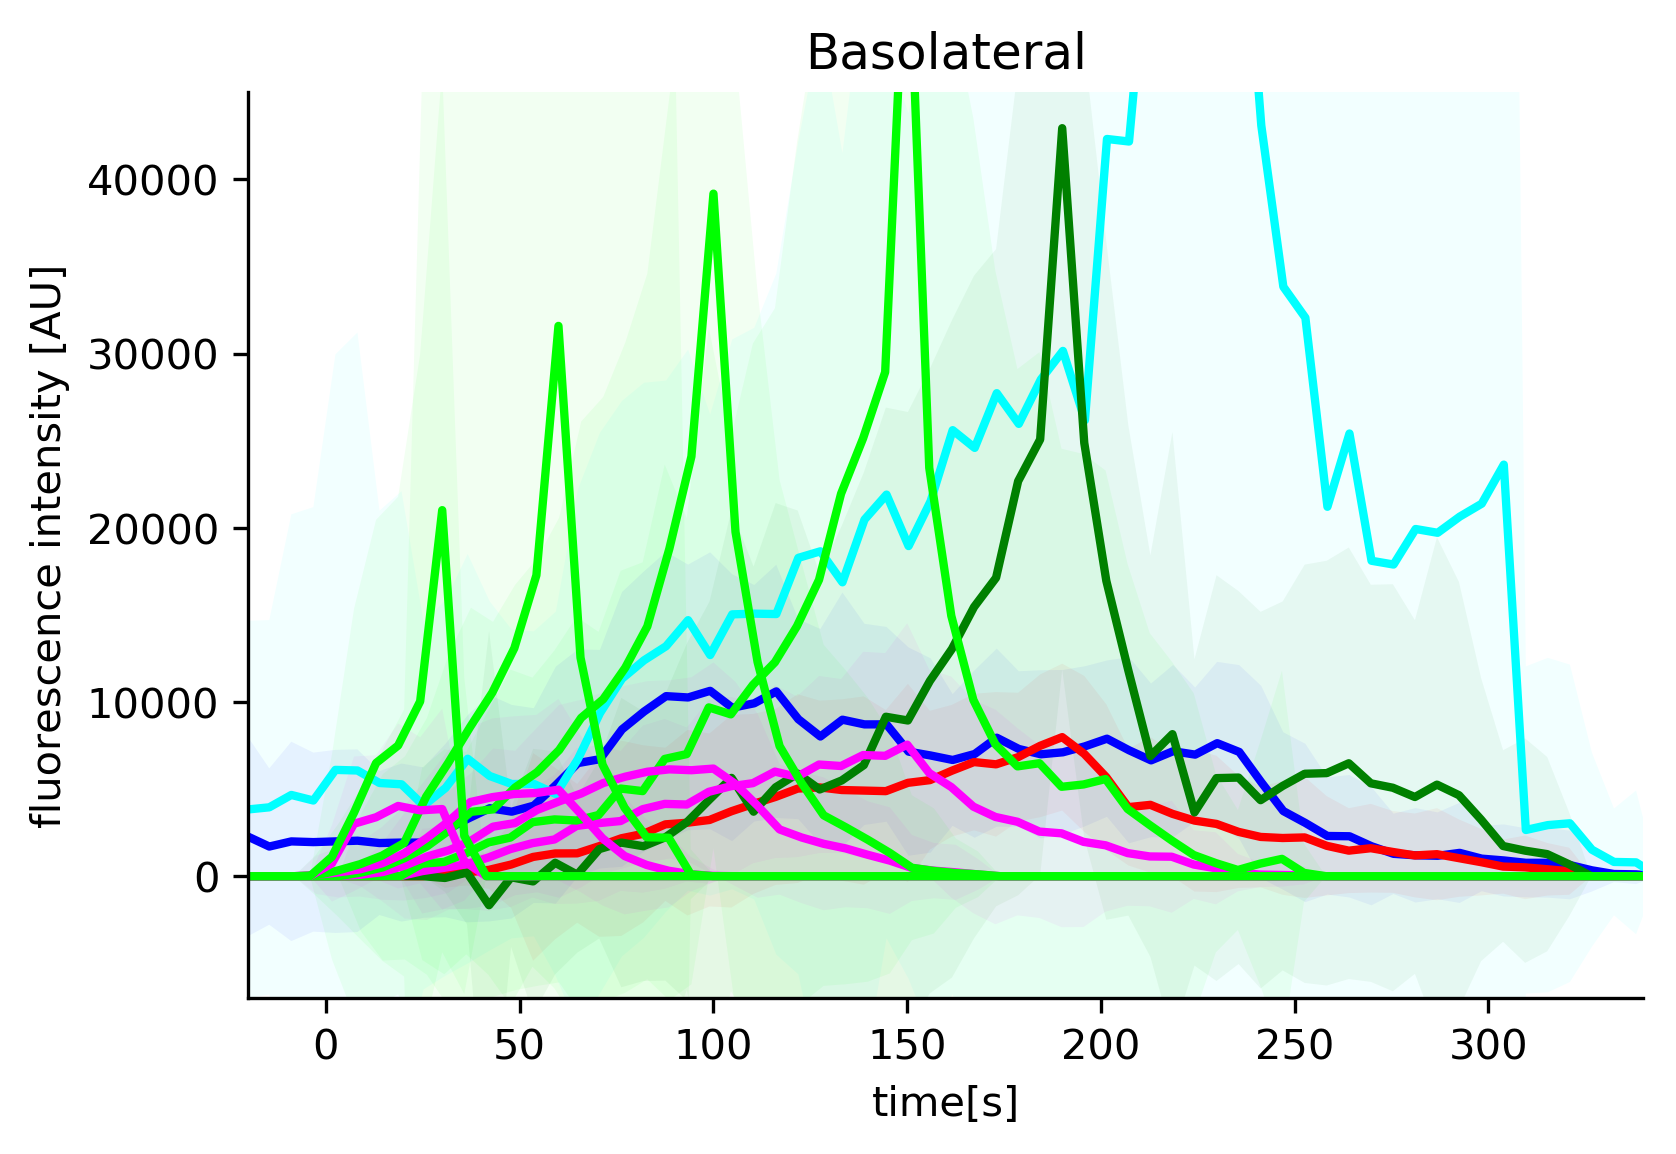

In [355]:

plt.figure(dpi=300)

#m_colors = ['magenta','red','crimson']
#s_colors = ['mediumspringgreen','lawngreen','lime']
m_colors = ['magenta','magenta','magenta','magenta','red','blue']
s_colors = ['lime','lime','lime','lime','green','cyan']
#timeShift = [0,40,95] this shift shifts everything to t=-40

bufferSize = 200
bufferZero = 100


timeShift = np.array([0,30,70,120,160,200]) +30
alph = 0.05
liwi = 2

lengthTreshold = 0


cohortIdx = 5
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):

    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)





#--------

cohortIdx = 4
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    print("test"+str(len(m_buffer)))
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)




#-------

cohortIdx = 3
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)

#--------

cohortIdx = 2
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)




#------

cohortIdx = 1
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)



#------

cohortIdx = 0
m_buffer,s_buffer = cohortBuffers[cohortIdx]
print(cohortIdx,len(m_buffer))
if(len(m_buffer)>lengthTreshold):
    m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
    s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
    m_buffer_std = np.nanstd(m_buffer,axis=0)
    s_buffer_std = np.nanstd(s_buffer,axis=0)
    time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]
    
    plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)
    
    plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
    plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-20,340)
plt.ylim(-7000,45000)
plt.xlabel('time[s]')
plt.ylabel('fluorescence intensity [AU]')
plt.title('Basolateral')

In [356]:
# taking only the real values

In [357]:
def avgAllColumns_ignoreValue(twoDArray,ignoredValue,replacementValue):
    len_ax1 = len(twoDArray[0])
    len_ax0 = len(twoDArray)
    print("len_ax0 "+str(len_ax0))
    print("len_ax1 "+str(len_ax1))
    result = []
    for i in range(0,len_ax1):
#        print(i)
        column = twoDArray[:,i]
#        print(column)
        excludedColumn = column[column != ignoredValue]
#        print(excludedColumn)
        if(len(excludedColumn) == 0):
            result.append(replacementValue)
        else:
            result.append(np.nanmean(excludedColumn))
    result = np.array(result)
    return result

In [ ]:
def stdAllColumns_ignoreValue(twoDArray,ignoredValue,replacementValue):
    len_ax1 = len(twoDArray[0])
    len_ax0 = len(twoDArray)
    print("len_ax0 "+str(len_ax0))
    print("len_ax1 "+str(len_ax1))
    result = []
    for i in range(0,len_ax1):
#        print(i)
        column = twoDArray[:,i]
#        print(column)
        excludedColumn = column[column != ignoredValue]
#        print(excludedColumn)
        if(len(excludedColumn) == 0):
            result.append(replacementValue)
        else:
            result.append(np.nanstd(excludedColumn))
    result = np.array(result)
    return result

In [ ]:
#calculate all the buffers for all cohorts
backgroundIntensity = -1

cohortBuffers = []
for i in range(0,len(lifetimeCohorts)):
    m_buffer, s_buffer = createBufferForLifetimeCohort(trackIdsAssignedToCohorts[i],backgroundIntensity)
    cohortBuffers.append([m_buffer,s_buffer])

m_buffer,s_buffer = cohortBuffers[1]
plt.figure(dpi=300)
plt.title('cltr')
plt.imshow(m_buffer)


plt.figure(dpi=300)
plt.title('dnm2')
plt.imshow(s_buffer)

In [ ]:

plt.figure(dpi=300)

#m_colors = ['magenta','red','crimson']
#s_colors = ['mediumspringgreen','lawngreen','lime']
m_colors = ['magenta','magenta','magenta','magenta']
s_colors = ['lime','lime','lime','lime']
#timeShift = [0,40,95] this shift shifts everything to t=-40

bufferSize = 200
bufferZero = 100



timeShift = np.array([0,30,70,120]) +30
alph = 0.05
liwi = 2


cohortIdx = 3
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = avgAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_average = avgAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
m_buffer_std = stdAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_std = stdAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)

#--------

cohortIdx = 2
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = avgAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_average = avgAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
m_buffer_std = stdAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_std = stdAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)




#------

cohortIdx = 1
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = avgAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_average = avgAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
m_buffer_std = stdAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_std = stdAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)



#------

cohortIdx = 0
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = avgAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_average = avgAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
m_buffer_std = stdAllColumns_ignoreValue(m_buffer,backgroundIntensity,0)
s_buffer_std = stdAllColumns_ignoreValue(s_buffer,backgroundIntensity,0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-20,300)
#plt.ylim(-7000,45000)
plt.xlabel('time[s]')
plt.ylabel('distance from start [px]')

In [ ]:
# normalize before putting into cohorts

In [ ]:
#calculate all the buffers for all cohorts
backgroundIntensity = 0

cohortBuffers = []
for i in range(0,len(lifetimeCohorts)):
    m_buffer, s_buffer = createBufferForLifetimeCohort_normalized(trackIdsAssignedToCohorts[i],backgroundIntensity)
    cohortBuffers.append([m_buffer,s_buffer])

m_buffer,s_buffer = cohortBuffers[1]
plt.figure(dpi=300)
plt.title('cltr')
plt.imshow(m_buffer)


plt.figure(dpi=300)
plt.title('dnm2')
plt.imshow(s_buffer)

In [ ]:

plt.figure(dpi=300)

#m_colors = ['magenta','red','crimson']
#s_colors = ['mediumspringgreen','lawngreen','lime']
m_colors = ['magenta','magenta','magenta','magenta']
s_colors = ['lime','lime','lime','lime']
#timeShift = [0,40,95] this shift shifts everything to t=-40

bufferSize = 200
bufferZero = 100


timeShift = np.array([0,30,70,120]) +30
alph = 0.05
liwi = 2


cohortIdx = 3
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
m_buffer_std = np.nanstd(m_buffer,axis=0)
s_buffer_std = np.nanstd(s_buffer,axis=0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)

#--------

cohortIdx = 2
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
m_buffer_std = np.nanstd(m_buffer,axis=0)
s_buffer_std = np.nanstd(s_buffer,axis=0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)




#------

cohortIdx = 1
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
m_buffer_std = np.nanstd(m_buffer,axis=0)
s_buffer_std = np.nanstd(s_buffer,axis=0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)



#------

cohortIdx = 0
m_buffer,s_buffer = cohortBuffers[cohortIdx]

m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
m_buffer_std = np.nanstd(m_buffer,axis=0)
s_buffer_std = np.nanstd(s_buffer,axis=0)
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)+timeShift[cohortIdx]

plt.plot(time,m_buffer_average,c=m_colors[cohortIdx],lw=liwi)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor=m_colors[cohortIdx],alpha=alph)

plt.plot(time,s_buffer_average,c=s_colors[cohortIdx],lw=liwi)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor=s_colors[cohortIdx],alpha=alph)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-20,240)
#plt.ylim(-7000,45000)
plt.xlabel('time[s]')
plt.ylabel('fluorescence intensity [AU]')

In [ ]:
m_buffer_average = (np.nanmean(m_buffer,axis=0)-backgroundIntensity)
m_buffer_average = m_buffer_average/max(m_buffer_average)
s_buffer_average = (np.nanmean(s_buffer,axis=0)-backgroundIntensity)/max(s_buffer_average)
s_buffer_average = s_buffer_average/max(s_buffer_average)

m_buffer_std = np.nanstd(m_buffer,axis=0)
m_buffer_std = m_buffer_std/max(m_buffer_std)
s_buffer_std = np.nanstd(s_buffer,axis=0)
s_buffer_std = s_buffer_std/max(s_buffer_std)

time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)

plt.figure(dpi=300)

plt.plot(time,m_buffer_average,c='magenta',lw=4)
plt.plot(time,m_buffer_average-m_buffer_std,c='magenta',lw=0.5)
plt.plot(time,m_buffer_average+m_buffer_std,c='magenta',lw=0.5)
plt.fill_between(time,m_buffer_average-m_buffer_std,m_buffer_average+m_buffer_std,facecolor='magenta',alpha=0.2)

plt.plot(time,s_buffer_average,c='lime',lw=5)
plt.plot(time,s_buffer_average-s_buffer_std,c='lime',lw=0.5)
plt.plot(time,s_buffer_average+s_buffer_std,c='lime',lw=0.5)
plt.fill_between(time,s_buffer_average-s_buffer_std,s_buffer_average+s_buffer_std,facecolor='lime',alpha=0.2)

plt.xlabel('time[s]')
plt.ylabel('norm. fl. intensity [AU]')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.ylim(-0.5,2.1)
plt.xlim(-120,100)

In [ ]:

m_buffer_average = np.nanmean(m_buffer,axis=0)-backgroundIntensity
s_buffer_average = np.nanmean(s_buffer,axis=0)-backgroundIntensity
time = framerate_msec/1000*(np.array(range(0,bufferSize))-bufferZero)
plt.figure(dpi=300)
plt.plot(time,m_buffer_average/max(m_buffer_average),c='magenta',lw=4)
plt.plot(time,s_buffer_average/max(s_buffer_average),c='lime',lw=5)
plt.xlabel('time[s]')
plt.ylabel('norm. fl. intensity [AU]')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-220,120)


In [ ]:
m_mean = []
s_mean = []
for i in range(0,bufferSize):
    m_mean.append(np.nanmean(m_buffer[i]))
    s_mean.append(np.nanmean(s_buffer[i]))
    
plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,m_mean, c='red')
plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,s_mean, c='green')

In [ ]:
#Lifetime Cohorts

In [ ]:
for tc in range(1,len(lifetimeCohorts)):

    m_buffer = []
    s_buffer = []
    bufferSize = 1000
    for i in range(0,bufferSize):
        m_buffer.append([])
        s_buffer.append([])
    
        
    for trackId in lifetimeCohorts[tc]:
        #print(trackId)
        track = data[data['trackId'] == trackId]
    
        m_intensity = track['m_A'].values.astype(float)
        s_intensity = track['s_A'].values.astype(float)
        
        #plt.plot(s_intensity)
        
        for i in range(0,len(track)):
            m_buffer[i].append(m_intensity[i])
            s_buffer[i].append(s_intensity[i])
            
    
    m_mean = []
    s_mean = []
    for i in range(0,bufferSize):
        m_mean.append(np.nanmean(m_buffer[i]))
        s_mean.append(np.nanmean(s_buffer[i]))
        
    plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,m_mean, c='red')
    plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,s_mean, c='green')

plt.xlabel('lifetime[s]')
plt.show()




In [ ]:
for tc in range(1,len(lifetimeCohorts)):

    m_buffer = []
    s_buffer = []
    bufferSize = 1000
    for i in range(0,bufferSize):
        m_buffer.append([])
        s_buffer.append([])
    
        
    for trackId in lifetimeCohorts[tc]:
        #print(trackId)
        track = data[data['trackId'] == trackId]
    
        m_intensity = track['m_A'].values.astype(float)
        s_intensity = track['s_A'].values.astype(float)
        
        #plt.plot(s_intensity)
        
        for i in range(0,len(track)):
            m_buffer[i].append(m_intensity[i])
            s_buffer[i].append(s_intensity[i])
            
    
    m_mean = []
    s_mean = []
    for i in range(0,bufferSize):
        m_mean.append(np.nanmean(m_buffer[i]))
        s_mean.append(np.nanmean(s_buffer[i]))
        
    plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,m_mean, c='red')
    plt.plot(np.arange(0,len(m_mean))*framerate_msec/1000,s_mean, c='green')

plt.xlabel('lifetime[s]')
plt.show()



In [ ]:
lifetimeThresholds = [1, 20, 40, 60, 80, 100, 120, 200]

lifetimeCohorts = []

dataBasis = cat_Ia_Tracks
for i in range(2,len(lifetimeThresholds)):
    lifetimeCohort_trackIds = np.unique(dataBasis.loc[(dataBasis["lifetime"] >= lifetimeThresholds[i-1]) & (dataBasis["lifetime"] < lifetimeThresholds[i]), "trackId"])
    print('number of tracks in cohort '+str(lifetimeThresholds[i-1])+'-'+str(lifetimeThresholds[i-1])+': '+str(len(lifetimeCohort_trackIds)))
    lifetimeCohorts.append(lifetimeCohort_trackIds)
#print(lifetimeCohorts)